In [2]:
#Importing Dependencies
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from timeit import default_timer as Timer
import mlxtend
import torchmetrics

In [4]:
#Writing device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [47]:
#Getting a dataset (Fashion-MNIST)
torch.cuda.manual_seed(42)
torch.manual_seed(42)
train_data = datasets.FashionMNIST(root=r'D:\Coding\Datasets',
                                   train=True,
                                   transform=ToTensor(),
                                   download=True,
                                   target_transform=None)

test_data = datasets.FashionMNIST(root=r'D:\Coding\Datasets',
                                  train=False,
                                  transform=ToTensor(),
                                  download=True,
                                  target_transform=None)

### 1. Visualizing the Data

(-0.5, 27.5, 27.5, -0.5)

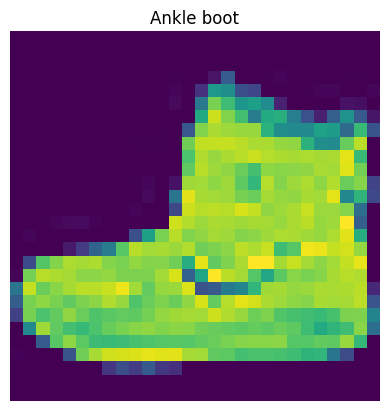

In [6]:
image, label = train_data[0]
class_names = train_data.classes
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)

37542
46067
46876
46414
10026
27335
38620
11924
14950
57113
31378
29014
47210
18954
18231
47572


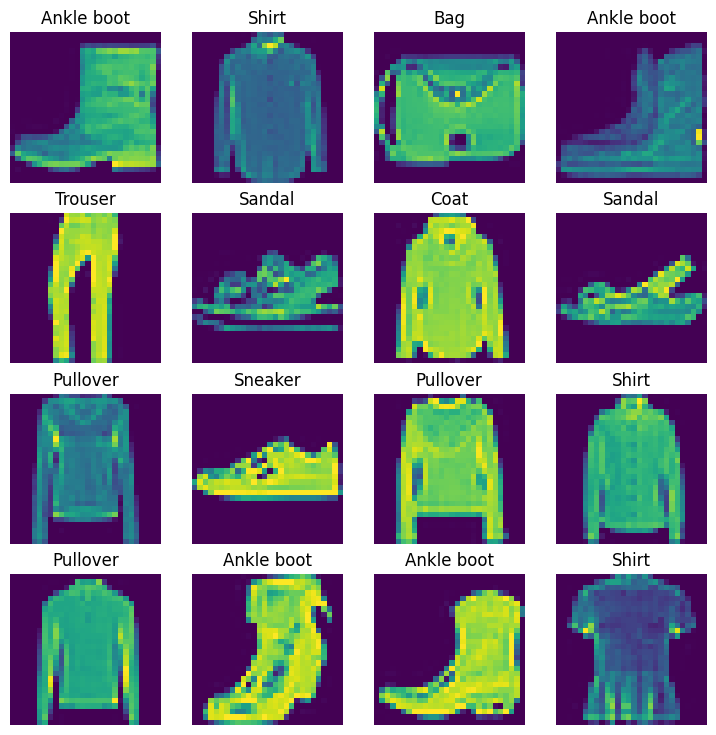

In [7]:
#visualizing some more images for better understanding of the data
class_to_idx = train_data.class_to_idx
rows, cols = 4,4
fig = plt.figure(figsize=(9,9))
torch.manual_seed(42)
for iter in range(1,rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    print(random_idx)
    img, label = train_data[random_idx]
    fig.add_subplot(rows,cols,iter)
    plt.imshow(img.squeeze())
    plt.title(class_names[label])
    plt.axis(False)

### 2. Preparing DataLoader


In [56]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
batch_size = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=False)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=batch_size,
                              shuffle=False)
print(f'Train Length --->         {len(train_dataloader)} batches of {train_dataloader.batch_size}')
print(f'Test Length --->         {len(test_dataloader)} batches of {test_dataloader.batch_size}')

Train Length --->         1875 batches of 32
Test Length --->         313 batches of 32


### 3. Building a Convolutional Neural Network also known as CNN
        ***you can explore https://poloclub.github.io/cnn-explainer/ for better understanding of how cnn works

In [9]:
#Create a convolutional neural network
class FashionMNIST_model_cnn(nn.Module):
    """Model architecture that replicates the TinyVGG model from
       CNN-explainer website mentioned in the above markdown cell
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,        # read pytorch documentation to understand how
                      stride=1,             # these hyperparameters work behind the scenes
                      padding=1),            # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,       #after flattening a 7*7 grid we get 49
                      out_features=output_shape)
        )
    
    def forward(self, X):
        X = self.conv_block_1(X)
        # print(X.shape)
        X = self.conv_block_2(X)
        # print(X.shape)
        X = self.classifier(X)
        return X

In [10]:
torch.manual_seed(42)
model_cnn = FashionMNIST_model_cnn(input_shape=1,       #depends on color channels of input images, which in our case is '1'
                                   hidden_units=10,
                                   output_shape=len(class_names)).to(device)

# model_cnn(image.to(device))         #checking the working of our model

### 4. Setup a loss function and optimizer and building the training loop

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_cnn.parameters(),
                            lr=0.1)

In [27]:
#building the training loop
epochs = 3
train_time = Timer()
for epoch in tqdm(range(epochs)):
    train_loss = 0
    for batches, (img,label) in enumerate(train_dataloader):
        model_cnn.train()
        
        #forward pass
        y_pred = model_cnn(img.to(device))
        
        #loss calculation
        loss = loss_fn(y_pred.to('cpu'), label)
        train_loss += loss
        
        #optimizer zero grad
        optimizer.zero_grad()
        
        #loss backward propagation
        loss.backward()
        
        #optimizer step
        optimizer.step()
        
        if(batches%400 == 0):
            print(f'Batch: {batches}')
    
    acc, test_loss = 0,0
    
    model_cnn.eval()
    with torch.inference_mode():
        for (img_test,label_test) in test_dataloader:
            test_pred = model_cnn(img_test.to(device))
            
            test_loss += loss_fn(test_pred, label_test.to(device))
            
            acc += accuracy_score(y_pred=test_pred.to('cpu').argmax(dim=1), y_true=label_test)
    
    
    print(f"Train Loss: {train_loss/len (train_dataloader)}      |       Test Loss: {test_loss/len(test_dataloader)}       |       Accuracy Score: {acc/len(test_dataloader)}")
    
train_time_end = Timer()
print(f'Total time taken: {train_time_end - train_time}')

  0%|          | 0/3 [00:00<?, ?it/s]

Batch: 0
Batch: 400
Batch: 800
Batch: 1200
Batch: 1600


 33%|███▎      | 1/3 [00:32<01:04, 32.45s/it]

Train Loss: 0.2966036796569824      |       Test Loss: 0.3212144076824188       |       Accuracy Score: 0.8872803514376997
Batch: 0
Batch: 400
Batch: 800
Batch: 1200
Batch: 1600


 67%|██████▋   | 2/3 [01:03<00:31, 31.83s/it]

Train Loss: 0.28111231327056885      |       Test Loss: 0.3148033022880554       |       Accuracy Score: 0.8838857827476039
Batch: 0
Batch: 400
Batch: 800
Batch: 1200
Batch: 1600


100%|██████████| 3/3 [01:34<00:00, 31.58s/it]

Train Loss: 0.27296197414398193      |       Test Loss: 0.2869712710380554       |       Accuracy Score: 0.8954672523961661
Total time taken: 94.75236250000034


In [28]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            #prepare the sample (add a batch dimension and pass to target device)
            sample = sample.unsqueeze(dim=0).to(device)
            # sample = sample.unsqueeze(dim=0).to(device)
            
            pred_logit = model(sample)
            
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            pred_probs.append(pred_prob.cpu())
            
    #stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [29]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

### 5.Visualizing the predicted outcomes

In [30]:
#making predicitons
pred = make_predictions(model=model_cnn,
                        data=test_samples)
print(pred)

tensor([[9.6253e-10, 7.8397e-12, 5.0315e-11, 2.6595e-10, 4.0647e-09, 9.9999e-01,
         1.3433e-08, 1.2267e-07, 1.5340e-07, 6.8252e-06],
        [2.1002e-01, 5.9624e-01, 4.4220e-03, 5.7740e-02, 6.1450e-02, 2.8459e-04,
         6.8532e-02, 4.7757e-04, 6.3328e-04, 2.0911e-04],
        [2.4287e-05, 2.4425e-08, 4.0001e-06, 3.1050e-07, 2.0056e-06, 6.0510e-04,
         3.0632e-06, 9.5690e-01, 6.1320e-04, 4.1845e-02],
        [7.0365e-04, 8.0285e-05, 3.1280e-01, 1.4307e-04, 6.8528e-01, 1.0735e-06,
         9.3914e-04, 3.9095e-07, 4.5412e-05, 9.7425e-06],
        [1.3120e-02, 1.5045e-06, 6.1454e-05, 9.8293e-01, 1.0834e-04, 1.7584e-05,
         3.6031e-03, 9.4599e-05, 4.0045e-05, 2.2977e-05],
        [4.1297e-01, 3.4688e-06, 1.1683e-03, 4.1027e-03, 7.2580e-03, 1.2196e-06,
         5.7405e-01, 4.0597e-06, 4.3774e-04, 1.2581e-06],
        [1.7788e-04, 3.5385e-06, 8.0844e-02, 6.5179e-07, 8.9005e-01, 2.2417e-07,
         2.8765e-02, 8.6513e-09, 1.5724e-04, 4.7241e-06],
        [7.3999e-06, 1.1312

In [31]:
#convert predictions probabilities into labels
pred_classes = pred.argmax(dim=1)
pred_classes, test_labels

(tensor([5, 1, 7, 4, 3, 6, 4, 7, 1]), [5, 1, 7, 4, 3, 0, 4, 7, 1])

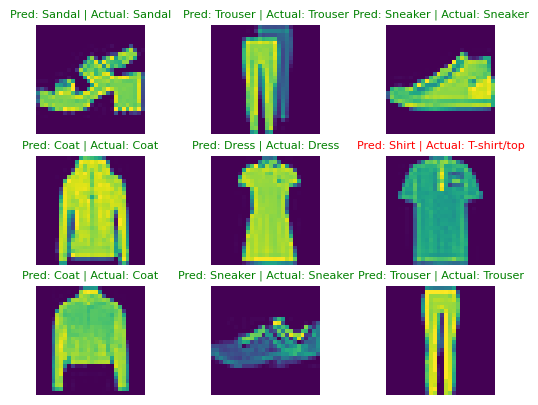

In [32]:
#plot predictions
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(sample.squeeze())
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Actual: {truth_label}"
    
    if pred_label==truth_label:
        plt.title(title_text, fontsize=8, c='g')
    else:
        plt.title(title_text, fontsize=8, c='r')
    plt.axis(False)
        

In [59]:
acc, test_loss = 0,0
test_stack = []
model_cnn.eval()
with torch.inference_mode():
    for (img_test,label_test) in test_dataloader:
        test_pred = model_cnn(img_test.to(device))   
        acc += accuracy_score(y_pred=test_pred.to('cpu').argmax(dim=1), y_true=label_test)
        test_stack.append(test_pred.to('cpu').argmax(dim=1))    
    
print(f"Accuracy Score: {acc/len(test_dataloader)*(100):.4f}%")
test_stack

Accuracy Score: 89.5767%


[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 5,
         1, 6, 6, 0, 9, 3, 8, 8]),
 tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 0, 9, 6, 7, 2, 1, 2, 6, 4, 4, 5, 8, 2, 2,
         8, 4, 8, 0, 7, 7, 8, 5]),
 tensor([1, 1, 3, 4, 7, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
         0, 2, 5, 3, 6, 7, 1, 8]),
 tensor([0, 1, 2, 2, 3, 6, 7, 2, 7, 8, 5, 7, 9, 4, 2, 5, 7, 0, 5, 2, 8, 4, 7, 8,
         0, 0, 9, 9, 3, 0, 8, 4]),
 tensor([1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 3, 2, 2, 2, 4,
         1, 4, 5, 0, 4, 7, 9, 3]),
 tensor([7, 2, 3, 9, 0, 9, 2, 7, 4, 2, 6, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6,
         7, 9, 9, 4, 4, 7, 1, 2]),
 tensor([3, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
         1, 6, 7, 2, 8, 5, 3, 0]),
 tensor([7, 7, 6, 6, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 2, 5, 6, 9, 2, 2, 8, 6, 4,
         6, 4, 9, 7, 6, 5, 5, 2]),
 tensor([8, 5, 2, 3, 0, 4, 8, 6, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 

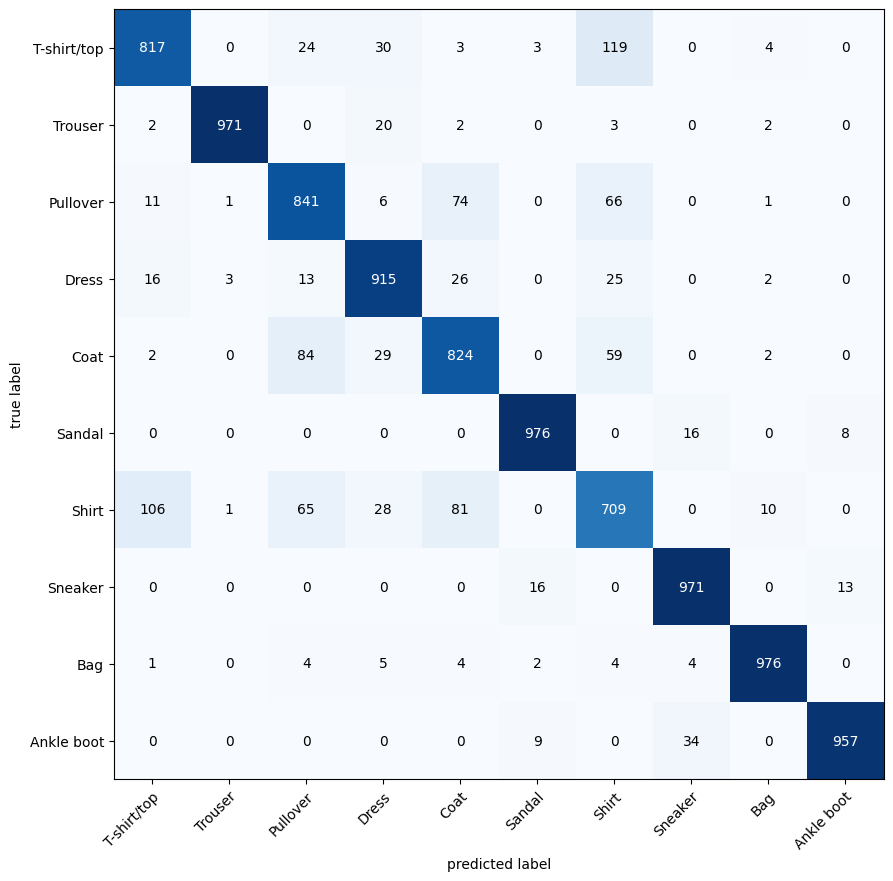

In [61]:
y_pred_tensor = torch.cat(test_stack)
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_names), task='multiclass')
confmat_tensor = confmat(y_pred_tensor,
                         test_data.targets)
#plotting the matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10,10))